In [ ]:
### 24시간뒤의 결로 발생확률 분석
# 결과 85% 정확도

# 48시간뒤의 결로 발생확률 분석을 해보자
# 85% 정확도로 비슷하다


#datetime을 기준으로 결로 발생여부를 뒤로 보내줘야한다.

#왜냐하면 중간중간 측정 간격이 변동되는 부분이 있어서 그럼
#방법: 같은 datetime에 있는 값을 if 'datetime' in datetime : 
#같은 datetime이 있으면 해당 datetime과 같은 인덱스의 ['24시간']에 해당 결

In [1]:
import pandas as pd
from numpy import mean
from scipy import stats #scipy란 과학기술 통계분석함수 모음이다.
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['axes.unicode_minus'] = False
import mglearn 
import missingno as msno
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import Dense,Activation,LSTM,Dropout
from keras.optimizers import Adam
from IPython .display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from numpy import argmax

Using TensorFlow backend.


In [2]:
plant1_trainnew=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_tem_hum.csv')
plant1_train=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_tem_hum24482.csv')
datanew=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/datanew.csv')

In [3]:
#결측치 제거
plant1_train=plant1_train.dropna(axis=0)


In [4]:
# 데이터형식을 float로 변경
plant1_train['tem_in_loc1'] = plant1_train['tem_in_loc1'].astype('float')
plant1_train['hum_in_loc1'] = plant1_train['hum_in_loc1'].astype('float')
plant1_train['tem_coil_loc1'] = plant1_train['tem_coil_loc1'].astype('float')
plant1_train['cond_loc1'] = plant1_train['cond_loc1'].astype('float')
plant1_train['24뒤'] = plant1_train['24뒤'].astype('float')
plant1_train['48뒤'] = plant1_train['48뒤'].astype('float')

In [5]:
#테스트 데이터와 label 분류(x1 <- 특성 데이터 / y1 <- Label 데이터)
x1=plant1_train.values[:,1:8]
y1=plant1_train.values[:,[9]] #일단 24시간뒤 결로발생여부로 예측
x1=x1.astype('float')
y1=y1.astype('float')

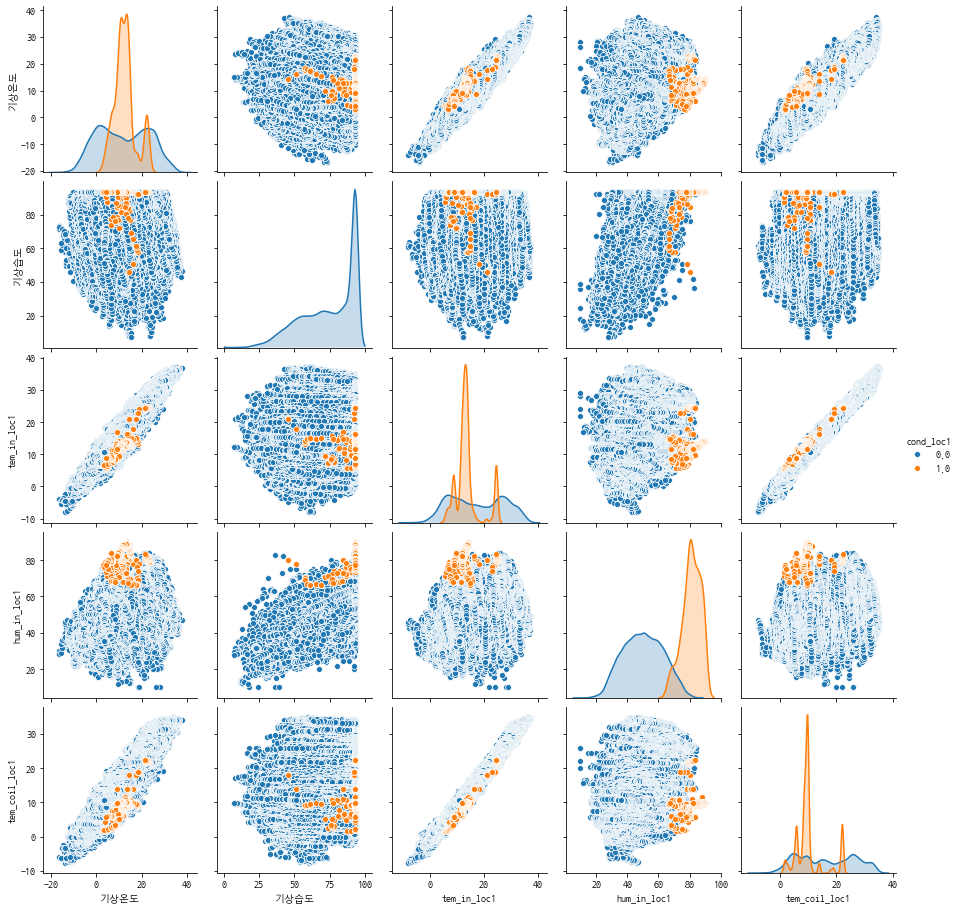

In [6]:
#문제는 결로 발생의 데이터가 275개로 매우 적고 반대로 결로 미발생은 5만건이 넘어서 분석시 그냥 0만 나와도 예측률이 좋게 나와버린다
#따라서 결로 미발생 건수를 줄이도록 한다.

sns.pairplot(plant1_train[['기상온도','기상습도','tem_in_loc1','hum_in_loc1','tem_coil_loc1','cond_loc1']], hue="cond_loc1")
plt.show()

In [7]:
#데이터 조건
#발생 데이터 조건 : 기상습도 > 70 / hum_in_loc1 > 60,tem_coil_loc1 < 15
#미발생 데이터 조건 : 무조건 미발생인 부분을 적출한다(데이터 줄이기)=과대적합 예방
#1) 기상온도 > 25 일경우 미발생
#2) tem_coil_loc1 > 20 / tem_coil_loc1 < 0 일경우 미발생
#3) hum_in_loc1 < 60일경우 미발생
#4) 기상습도 <60 일경우 미발생
#5) hum_in_loc1<60일경우 미발생

In [8]:
x_data_cond1=plant1_train[(plant1_train['기상습도']>=70)&(plant1_train['cond_loc1']==1)&(plant1_train['hum_in_loc1']>60)&(plant1_train['tem_coil_loc1']<13)]
#조건만족 229개

x_data_cond0=plant1_train[(plant1_train['기상온도']<=25)&(plant1_train['cond_loc1']==0)&(plant1_train['tem_coil_loc1']<=12.5)&(plant1_train['tem_coil_loc1']>0)&(plant1_train['기상습도']>60)&(plant1_train['hum_in_loc1']>65)]

x_data_cond0
#조건만족 998개
x_data_cond1
#조건만족 224개

,일시,기상온도,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_out_loc1,hum_out_loc1,cond_loc1,24뒤,48뒤
2056,2016-12-22 0:00,14.2,93.4,13.2,81.62,10.86,11.53,92.64,1.0,0.0,0.0
2057,2016-12-22 3:00,12.6,93.4,14.1,87.76,11.51,12.99,90.35,1.0,0.0,0.0
2093,2017-01-27 2:00,3.7,93.4,7.0,78.79,4.26,4.96,82.30,1.0,0.0,0.0
2583,2017-02-16 18:00,11.5,81.3,11.6,68.01,6.05,12.20,68.25,1.0,1.0,0.0
2584,2017-02-16 19:00,10.8,85.1,11.6,72.99,6.09,11.98,72.22,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49545,2019-02-03 16:00,5.6,93.4,9.0,80.34,5.98,6.21,88.16,1.0,0.0,0.0
49546,2019-02-03 16:10,5.0,93.4,9.0,79.82,6.05,5.91,87.94,1.0,0.0,0.0
49547,2019-02-03 16:20,4.7,93.4,8.9,78.91,5.94,5.73,87.73,1.0,0.0,0.0
49548,2019-02-03 16:30,4.6,93.4,8.8,78.21,5.90,5.51,87.76,1.0,0.0,0.0


In [9]:
#datanew=pd.concat([x_data_cond0,x_data_cond1])

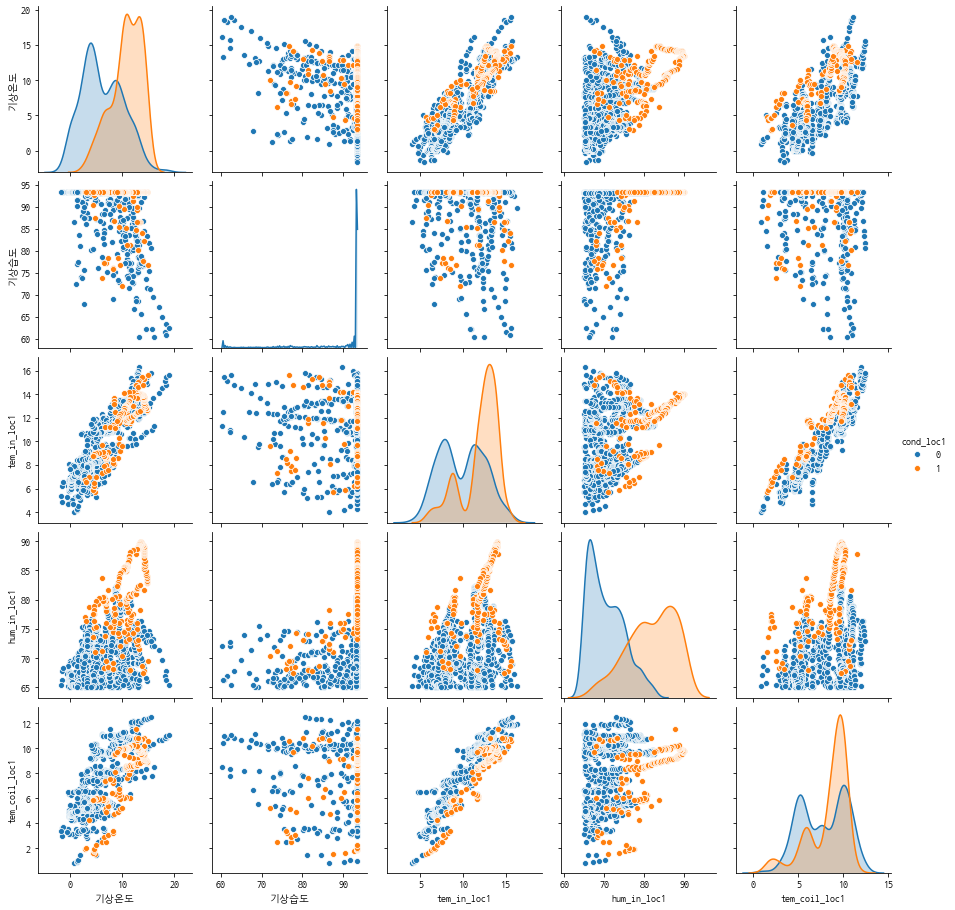

In [48]:
#새롭게 전처리한 데이터로 분석
sns.pairplot(datanew[['기상온도','기상습도','tem_in_loc1','hum_in_loc1','tem_coil_loc1','cond_loc1']], hue="cond_loc1")
plt.show()

In [11]:
# datanew['일시']

# datanew['일시']= pd.to_datetime(plant1_trainnew['일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [12]:
# del datanew['Unnamed: 0']

In [13]:
#각 인덱스 별로 24시간전 시간 컬럼을 생성해준다.

# datanew['24시간'] = pd.DatetimeIndex(datanew['일시']) - timedelta(hours=24)
# datanew['48시간'] = pd.DatetimeIndex(datanew['일시']) - timedelta(hours=48)
# datanew['24']=np.NaN
# datanew['48']=np.NaN

In [14]:
# datanew=datanew.reset_index(drop=True, inplace=False)

In [15]:
# datanew

<img src="./csvdata/hyundae/ana.png" width="600" height="300">

In [16]:
# #이제 24HOUR_after와 같은 `일시`의 cond_loc1을 가져오면 된다.
# for i in range(datanew.shape[0]):
#     date=datanew['일시'][i]
#     for j in range(datanew.shape[0]):
#         if date==datanew['24시간'][j]:
#             datanew['24'][j]=datanew['cond_loc1'][i]
#             print('24',datanew['24시간'][j])
            
#         elif date==datanew['48시간'][j]:
#             datanew['48'][j]=datanew['cond_loc1'][i]
#             print('48',datanew['48시간'][j])
            
#         else:
#             pass

In [17]:
datanew=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/dataconvert.csv')

In [18]:
# datanew의 24와 48 컬럼은 각각 24,48시간뒤 결로 발생 여부를 의미한다.
# 원본데이터의 cond_loc1은 해당 온도와 습도를 측정할때 같이 측정한 값이라 24시간,48시간 뒤의 예측모델을 구성하기위해
# 이런작업을 한것임
datanew.isna().sum() #결측치가 21,27개밖에 없다 다행이다.

Unnamed: 0        0
일시                0
기상온도              0
기상습도              0
tem_in_loc1       0
hum_in_loc1       0
tem_coil_loc1     0
tem_out_loc1      0
hum_out_loc1      0
cond_loc1         0
24시간              0
48시간              0
24               21
48               27
dtype: int64

In [19]:
datanew=datanew.dropna(axis=0)
datanew=datanew.reset_index(drop=True, inplace=False)
datanew

,Unnamed: 0,일시,기상온도,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_out_loc1,hum_out_loc1,cond_loc1,24시간,48시간,24,48
0,16,2016-04-03 00:00:00,5.5,93.4,10.6,69.14,9.95,6.03,91.48,0,2016-04-02 00:00:00,2016-04-01 00:00:00,0.0,0.0
1,17,2016-04-03 03:00:00,5.0,93.4,10.0,69.93,9.79,5.51,87.03,0,2016-04-02 03:00:00,2016-04-01 03:00:00,0.0,0.0
2,18,2016-04-03 06:00:00,9.9,82.3,10.6,71.31,9.87,6.40,87.33,0,2016-04-02 06:00:00,2016-04-01 06:00:00,0.0,0.0
3,19,2016-04-03 09:00:00,5.7,93.4,9.3,65.14,9.87,5.91,81.23,0,2016-04-02 09:00:00,2016-04-01 09:00:00,0.0,0.0
4,20,2016-04-03 12:00:00,11.3,76.4,11.3,66.88,10.18,11.28,60.29,0,2016-04-02 12:00:00,2016-04-01 12:00:00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1235,2016-09-04 00:00:00,5.6,93.4,9.0,80.34,5.98,6.21,88.16,1,2016-09-03 00:00:00,2016-09-02 00:00:00,1.0,1.0
1196,1236,2016-09-04 03:00:00,5.0,93.4,9.0,79.82,6.05,5.91,87.94,1,2016-09-03 03:00:00,2016-09-02 03:00:00,1.0,1.0
1197,1237,2016-09-04 06:00:00,4.7,93.4,8.9,78.91,5.94,5.73,87.73,1,2016-09-03 06:00:00,2016-09-02 06:00:00,1.0,1.0
1198,1238,2016-09-04 09:00:00,4.6,93.4,8.8,78.21,5.90,5.51,87.76,1,2016-09-03 09:00:00,2016-09-02 09:00:00,1.0,1.0


In [20]:
#datanew의 결로발생 데이터의 각 갯수를 알아보자
print(datanew[datanew['cond_loc1']==0].shape) # 222개 / 978개
print(datanew[datanew['24']==0].shape) # 214개 / 986개
print(datanew[datanew['48']==0].shape) #206개 / 994개

(978, 14)
(986, 14)
(994, 14)


In [21]:
del datanew['Unnamed: 0']

In [22]:
#svc 모델로 간단하게 예측해보자 (입력 특성 tem,hum,tem_coil)
from sklearn.svm import SVC
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix

In [23]:
x1=datanew.iloc[:,1:8] #기상데이터
y1=datanew.iloc[:,11] #11=24시간뒤 결로 발생여부 12=48시간뒤 발생여부

In [24]:
x1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   기상온도           1200 non-null   float64
 1   기상습도           1200 non-null   float64
 2   tem_in_loc1    1200 non-null   float64
 3   hum_in_loc1    1200 non-null   float64
 4   tem_coil_loc1  1200 non-null   float64
 5   tem_out_loc1   1200 non-null   float64
 6   hum_out_loc1   1200 non-null   float64
dtypes: float64(7)
memory usage: 65.8 KB


In [25]:
X_train, X_test, y_train, y_test =train_test_split(x1, y1, random_state=0)

svc = SVC().fit(X_train, y_train)

print('훈련세트점수: {:.3f}'.format(svc.score(X_train, y_train)))
print('검증세트점수: {:.3f}'.format(svc.score(X_test, y_test)))
#결과
# 훈련세트점수: 0.995
# 검증세트점수: 0.995

훈련세트점수: 0.926
검증세트점수: 0.877


In [26]:
y_pred = svc.predict(X_test)
# 예측값 y_pred와 실제값 y_test의 결과가 얼마나 일치하는지 시각화해서 확인해보자
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93       272
         1.0       0.43      1.00      0.60        28

    accuracy                           0.88       300
   macro avg       0.72      0.93      0.76       300
weighted avg       0.95      0.88      0.90       300



In [27]:
confusion_matrix(y_test, y_pred)

array([[235,   0],
       [ 37,  28]], dtype=int64)

In [28]:
x1=x1[['기상온도','기상습도']] #나머지 싹빼고 기상온도와 습도만으로 결로 발생여부를 예측해보자


In [29]:
#########################################################
############################딥러닝########################
X_train,X_test,y_train,y_test=train_test_split(x1,y1,test_size=0.2,random_state=7)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((960, 2), (240, 2), (960,), (240,))

In [30]:
#step 1. 모델 <- 측정당시 결로여부 예측모델
model = Sequential()
model.add(Dense(32,input_dim=2, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 모델 24 <- 24시간뒤 결로발생 예측모델
model24 = Sequential()
model24.add(Dense(32,input_dim=2, activation='relu'))
model24.add(Dropout(0.7))
model24.add(Dense(1, activation='sigmoid'))
model24.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model24.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                96        
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [32]:
#step 1. 모델 생성(결로발생/미발생 2진분류 <- sigmoid 사용)
# model48 = Sequential()
# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dropout(0.7))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
# 83.33 #최대 확률 0.33

# model48 = Sequential()
# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dropout(0.5))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
#83.33 : 0.388

# model48 = Sequential()
# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dropout(0.2))
# model48.add(Dense(1, activation='sigmoid'))
#83.75 # 0.5064

# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dropout(0.2))
# 83.75% / 0.9406732

# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dropout(0.2))
#85.42% / 0.5942017 -> 훈련횟수 300->600 *(83.33% /0.7678743)

# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dropout(0.2))
# 83.75 0.54425794


# model48 = Sequential()
# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.2))
# 84.58 / 0.92136234

# model48 = Sequential()
# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.5))
#84.58% 0.9007228

# model48 = Sequential()
# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.7))
#82.5 / 0.7661929

# model48 = Sequential()
# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.2))
#83.75 / 0.80235296

# model48 = Sequential()
# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dropout(0.2))
#85.42 / 0.5

# model48.add(Dense(32,input_dim=2, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.2))
# 85.83 / 0.87368953


# model48 = Sequential()
# model48.add(Dense(16,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dropout(0.7))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
#86.67 / 0.943748


# model48 = Sequential()
# model48.add(Dense(16,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dropout(0.2))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
# 85.42 / 0.98485696

# model48 = Sequential()
# model48.add(Dense(16,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dropout(0.7))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
#86.25% / 0.9695263


# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dropout(0.7))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
# 87.08% / 0.94

# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu'))
# model48.add(Dense(16, activation='relu'))
# model48.add(Dense(16, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(32, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.7))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
# 86.67 / 0.897076 / 0.84355944

# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.5))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
#87.50 0.9382348 0.9


# 2번째로 괜찮은 녀석
# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.7))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
#85.42% /0.988907 / 0.95870477

# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.2))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
# 88.75% / 0.9794781 / 0.9722254
 
    
    
# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu',kernel_initializer='uniform'))
# model48.add(Dense(100, activation='relu',kernel_initializer='uniform'))
# model48.add(Dense(100, activation='relu',kernel_initializer='uniform'))
# model48.add(Dense(64, activation='relu',kernel_initializer='uniform'))
# model48.add(Dense(64, activation='relu',kernel_initializer='uniform'))
# model48.add(Dense(64, activation='relu',kernel_initializer='uniform'))
# model48.add(Dense(64, activation='relu',kernel_initializer='uniform'))
# model48.add(Dense(64, activation='relu',kernel_initializer='uniform'))
# model48.add(Dropout(0.2))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
# 87.50% / 0.94920033 / 0.9433549   


# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu',kernel_initializer='uniform'))
# model48.add(Dense(100, activation='relu',kernel_initializer='he_uniform'))
# model48.add(Dense(100, activation='relu',kernel_initializer='he_uniform'))
# model48.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
# model48.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
# model48.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
# model48.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
# model48.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
# model48.add(Dropout(0.2))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
#82.50%

# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.2))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
# 86.67%


# model48 = Sequential()
# model48.add(Dense(100,input_dim=2, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(30, activation='relu'))
# model48.add(Dense(30, activation='relu'))
# model48.add(Dropout(0.2))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
# 85.42%

# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.5))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
# 87.50% / 0.99197936 / 0.98765427

# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(100, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.7))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
#87.92% / 0.8241046 /0.7380846

# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.2))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
#86.67% / 0.84383696 / 0.8092


# model48 = Sequential()
# model48.add(Dense(8,input_dim=2, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dense(64, activation='relu'))
# model48.add(Dropout(0.7))
# model48.add(Dense(1, activation='sigmoid'))
# model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# model48.summary()
# 84.58% 0.95109767 0.9344


model48 = Sequential()
model48.add(Dense(8,input_dim=2, activation='relu'))
model48.add(Dense(100, activation='relu'))
model48.add(Dense(100, activation='relu'))
model48.add(Dense(64, activation='relu'))
model48.add(Dense(64, activation='relu'))
model48.add(Dense(64, activation='relu'))
model48.add(Dense(64, activation='relu'))
model48.add(Dense(64, activation='relu'))
model48.add(Dropout(0.2))
model48.add(Dense(1, activation='sigmoid'))
model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model48.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 100)               900       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)               

In [33]:
#step 2. 모델학습
hist= model48.fit(X_train,y_train,epochs=300,verbose=1,validation_data=(X_test,y_test))

Train on 960 samples, validate on 240 samples
Epoch 1/300
960/960 [==============================] - 0s 358us/step - loss: 0.4763 - accuracy: 0.8073 - val_loss: 0.4425 - val_accuracy: 0.8292
Epoch 2/300
960/960 [==============================] - 0s 50us/step - loss: 0.4311 - accuracy: 0.8073 - val_loss: 0.3714 - val_accuracy: 0.8292
Epoch 3/300
960/960 [==============================] - 0s 47us/step - loss: 0.3895 - accuracy: 0.8052 - val_loss: 0.3678 - val_accuracy: 0.8292
Epoch 4/300
960/960 [==============================] - 0s 50us/step - loss: 0.3912 - accuracy: 0.8146 - val_loss: 0.3982 - val_accuracy: 0.8292
Epoch 5/300
960/960 [==============================] - 0s 49us/step - loss: 0.4143 - accuracy: 0.8115 - val_loss: 0.3729 - val_accuracy: 0.8292
Epoch 6/300
960/960 [==============================] - 0s 47us/step - loss: 0.3838 - accuracy: 0.8188 - val_loss: 0.3779 - val_accuracy: 0.8292
Epoch 7/300
960/960 [==============================] - 0s 50us/step - loss: 0.3924 - accu

960/960 [==============================] - 0s 50us/step - loss: 0.3599 - accuracy: 0.8250 - val_loss: 0.3752 - val_accuracy: 0.8250
Epoch 58/300
960/960 [==============================] - 0s 49us/step - loss: 0.3602 - accuracy: 0.8438 - val_loss: 0.3677 - val_accuracy: 0.8208
Epoch 59/300
960/960 [==============================] - 0s 48us/step - loss: 0.3625 - accuracy: 0.8281 - val_loss: 0.3613 - val_accuracy: 0.8250
Epoch 60/300
960/960 [==============================] - 0s 48us/step - loss: 0.3518 - accuracy: 0.8375 - val_loss: 0.3713 - val_accuracy: 0.8083
Epoch 61/300
960/960 [==============================] - 0s 47us/step - loss: 0.3522 - accuracy: 0.8375 - val_loss: 0.3664 - val_accuracy: 0.8042
Epoch 62/300
960/960 [==============================] - 0s 50us/step - loss: 0.3557 - accuracy: 0.8323 - val_loss: 0.4426 - val_accuracy: 0.8208
Epoch 63/300
960/960 [==============================] - 0s 48us/step - loss: 0.3775 - accuracy: 0.8156 - val_loss: 0.3771 - val_accuracy: 0.820

960/960 [==============================] - 0s 47us/step - loss: 0.3476 - accuracy: 0.8490 - val_loss: 0.3754 - val_accuracy: 0.8375
Epoch 114/300
960/960 [==============================] - 0s 51us/step - loss: 0.3401 - accuracy: 0.8469 - val_loss: 0.3703 - val_accuracy: 0.8292
Epoch 115/300
960/960 [==============================] - 0s 51us/step - loss: 0.3510 - accuracy: 0.8396 - val_loss: 0.3817 - val_accuracy: 0.8167
Epoch 116/300
960/960 [==============================] - 0s 52us/step - loss: 0.3490 - accuracy: 0.8438 - val_loss: 0.3708 - val_accuracy: 0.8125
Epoch 117/300
960/960 [==============================] - 0s 50us/step - loss: 0.3517 - accuracy: 0.8500 - val_loss: 0.3657 - val_accuracy: 0.8208
Epoch 118/300
960/960 [==============================] - 0s 47us/step - loss: 0.3532 - accuracy: 0.8406 - val_loss: 0.3667 - val_accuracy: 0.8167
Epoch 119/300
960/960 [==============================] - 0s 55us/step - loss: 0.3397 - accuracy: 0.8521 - val_loss: 0.3791 - val_accuracy:

960/960 [==============================] - 0s 53us/step - loss: 0.3276 - accuracy: 0.8562 - val_loss: 0.3631 - val_accuracy: 0.8542
Epoch 170/300
960/960 [==============================] - 0s 54us/step - loss: 0.3305 - accuracy: 0.8542 - val_loss: 0.3744 - val_accuracy: 0.8333
Epoch 171/300
960/960 [==============================] - 0s 51us/step - loss: 0.3251 - accuracy: 0.8521 - val_loss: 0.3457 - val_accuracy: 0.8458
Epoch 172/300
960/960 [==============================] - 0s 47us/step - loss: 0.3285 - accuracy: 0.8542 - val_loss: 0.3488 - val_accuracy: 0.8417
Epoch 173/300
960/960 [==============================] - 0s 46us/step - loss: 0.3242 - accuracy: 0.8604 - val_loss: 0.3599 - val_accuracy: 0.8458
Epoch 174/300
960/960 [==============================] - 0s 46us/step - loss: 0.3230 - accuracy: 0.8615 - val_loss: 0.3468 - val_accuracy: 0.8417
Epoch 175/300
960/960 [==============================] - 0s 48us/step - loss: 0.3245 - accuracy: 0.8615 - val_loss: 0.3621 - val_accuracy:

960/960 [==============================] - 0s 50us/step - loss: 0.3176 - accuracy: 0.8635 - val_loss: 0.3362 - val_accuracy: 0.8583
Epoch 226/300
960/960 [==============================] - 0s 52us/step - loss: 0.3260 - accuracy: 0.8583 - val_loss: 0.3733 - val_accuracy: 0.8500
Epoch 227/300
960/960 [==============================] - 0s 53us/step - loss: 0.3246 - accuracy: 0.8531 - val_loss: 0.3687 - val_accuracy: 0.8458
Epoch 228/300
960/960 [==============================] - 0s 52us/step - loss: 0.3189 - accuracy: 0.8781 - val_loss: 0.3347 - val_accuracy: 0.8708
Epoch 229/300
960/960 [==============================] - 0s 52us/step - loss: 0.3379 - accuracy: 0.8385 - val_loss: 0.3471 - val_accuracy: 0.8500
Epoch 230/300
960/960 [==============================] - 0s 51us/step - loss: 0.3376 - accuracy: 0.8427 - val_loss: 0.3452 - val_accuracy: 0.8500
Epoch 231/300
960/960 [==============================] - 0s 47us/step - loss: 0.3170 - accuracy: 0.8698 - val_loss: 0.3590 - val_accuracy:

Epoch 281/300
960/960 [==============================] - 0s 49us/step - loss: 0.3165 - accuracy: 0.8615 - val_loss: 0.3494 - val_accuracy: 0.8500
Epoch 282/300
960/960 [==============================] - 0s 50us/step - loss: 0.3213 - accuracy: 0.8604 - val_loss: 0.3414 - val_accuracy: 0.8500
Epoch 283/300
960/960 [==============================] - 0s 49us/step - loss: 0.3148 - accuracy: 0.8625 - val_loss: 0.3310 - val_accuracy: 0.8792
Epoch 284/300
960/960 [==============================] - 0s 46us/step - loss: 0.3089 - accuracy: 0.8687 - val_loss: 0.3525 - val_accuracy: 0.8583
Epoch 285/300
960/960 [==============================] - 0s 48us/step - loss: 0.3170 - accuracy: 0.8615 - val_loss: 0.3548 - val_accuracy: 0.8583
Epoch 286/300
960/960 [==============================] - 0s 49us/step - loss: 0.3109 - accuracy: 0.8667 - val_loss: 0.3570 - val_accuracy: 0.8500
Epoch 287/300
960/960 [==============================] - 0s 48us/step - loss: 0.3202 - accuracy: 0.8583 - val_loss: 0.3399 -

In [34]:
scores= model48.evaluate(X_test,y_test)
print('%s : %.2f%%' %(model.metrics_names[1],scores[1]*100))


240/240 [==============================] - 0s 21us/step
accuracy : 85.00%


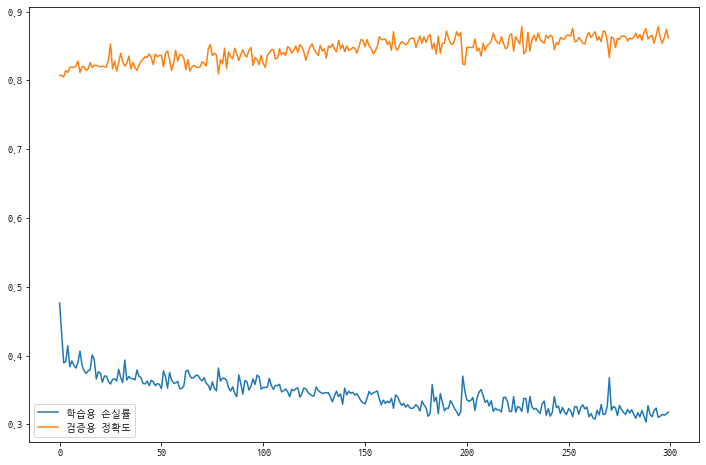

In [35]:
# setp 5. 시각화
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) # 학습용 데이터셋의 손실율
plt.plot(hist.history['accuracy']) # 학습용 데이터셋의 정확도
plt.legend(['학습용 손실률', '검증용 정확도'])
plt.show()

In [36]:
##학습한 모델을 토대로 결로가 발생한 데이터로 각 예측모델의 확률을 정리해보자
# 모델48은 48시간뒤의 예측모델이다.

list3=[]
dictf={}
# x_data_cond1[:,1:3]은 datanew의 기상온도/기상습도를 의미한다.
for i in range(x_data_cond1.shape[0]):
    list3.append(model48.predict(x_data_cond1.values[i,1:3].reshape(1,2))[0][0])
    dictf[str(model48.predict(x_data_cond1.values[i,1:3].reshape(1,2))[0][0])] = (x_data_cond1.values[i,1:3])
    

In [37]:
sorted(list3,reverse=True)[0:10] #확률 상위 10개만 보자

[0.96696556,
 0.96696556,
 0.96696556,
 0.96696556,
 0.96065074,
 0.96065074,
 0.9531093,
 0.9441831,
 0.9441831,
 0.93367577]

In [38]:
#확률이 가장 낮은 얘들만 출력해보자
lst=[]
for i in list3:
    if i < 0.5:
        lst.append(i)

In [39]:
len(lst) # 102개


104

In [40]:
#48시간뒤 결로 미발생 예측모델
list4=[]
for i in range(x_data_cond0.shape[0]):
    list4.append(model48.predict(x_data_cond0.values[i,1:3].reshape(1,2))[0][0])
    

In [41]:
sorted(list4,reverse=True)[0:10] #확률 상위 10개만 보자

[0.9178541,
 0.8923636,
 0.87009007,
 0.773554,
 0.6861199,
 0.6392796,
 0.63813514,
 0.6380416,
 0.6380416,
 0.637409]

In [42]:
lst2=[]
for i in list4:
    if i<0.5:
        lst2.append(i)

In [43]:
len(lst) #120개가 50%이하

104

In [44]:
len(list3)



224

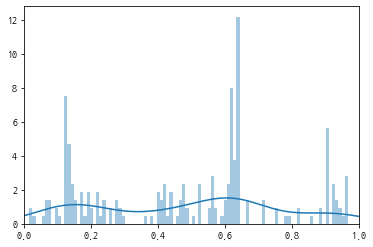

In [45]:
#결로발생시의 각 데이터별 결로발생확률값 분포도
sns.distplot(list3,bins=100) 
stats.probplot(list3)
plt.xlim(0,1)
plt.show()

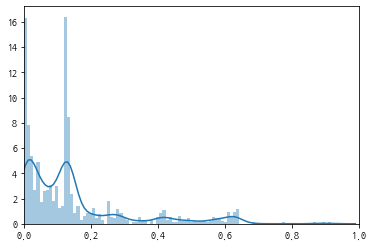

In [46]:
#결로 미발생시 각 데이터별 결로발생확률값 분포도
sns.distplot(list4,bins=100) 
stats.probplot(list4)
plt.xlim(0,1)
plt.show()

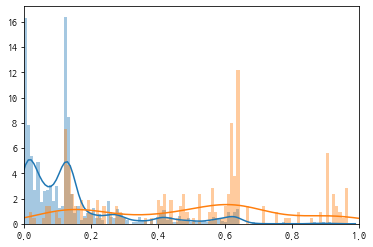

In [47]:
#결로발생,미발생시의 각 데이터별 48시간후 결로발생 확률값 분포도
sns.distplot(list4,bins=100) 
stats.probplot(list4)
sns.distplot(list3,bins=100) 
stats.probplot(list3)
plt.xlim(0,1)
plt.show()

In [192]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


 

In [217]:
################# K-FOLD방법############################################################

def create_model():
    # create model
    model48 = Sequential()
    model48.add(Dense(8,input_dim=2, activation='relu'))
    model48.add(Dense(100, activation='relu'))
    model48.add(Dense(100, activation='relu'))
    model48.add(Dense(64, activation='relu'))
    model48.add(Dense(64, activation='relu'))
    model48.add(Dense(64, activation='relu'))
    model48.add(Dense(64, activation='relu'))
    model48.add(Dense(64, activation='relu'))
    model48.add(Dropout(0.2))
    model48.add(Dense(1, activation='sigmoid'))
    model48.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    model48.summary()
    return model48

# create model
model = KerasClassifier(build_fn=create_model, epochs=300, batch_size=10, verbose=1)
 
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
results = cross_val_score(model, X_train,y_train, cv=kfold)

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_467 (Dense)            (None, 8)                 24        
_________________________________________________________________
dense_468 (Dense)            (None, 100)               900       
_________________________________________________________________
dense_469 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_470 (Dense)            (None, 64)                6464      
_________________________________________________________________
dense_471 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_472 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_473 (Dense)            (None, 64)              

768/768 [==============================] - 0s 113us/step - loss: 0.3295 - accuracy: 0.8659
Epoch 142/300
768/768 [==============================] - 0s 116us/step - loss: 0.3285 - accuracy: 0.8503
Epoch 143/300
768/768 [==============================] - 0s 142us/step - loss: 0.3282 - accuracy: 0.8568
Epoch 144/300
768/768 [==============================] - 0s 130us/step - loss: 0.3275 - accuracy: 0.8581
Epoch 145/300
768/768 [==============================] - 0s 112us/step - loss: 0.3279 - accuracy: 0.8607
Epoch 146/300
768/768 [==============================] - 0s 112us/step - loss: 0.3200 - accuracy: 0.8659
Epoch 147/300
768/768 [==============================] - 0s 110us/step - loss: 0.3127 - accuracy: 0.8633
Epoch 148/300
768/768 [==============================] - 0s 112us/step - loss: 0.3152 - accuracy: 0.8581
Epoch 149/300
768/768 [==============================] - 0s 130us/step - loss: 0.3243 - accuracy: 0.8646
Epoch 150/300
768/768 [==============================] - 0s 131us/ste

768/768 [==============================] - 0s 117us/step - loss: 0.3188 - accuracy: 0.8594
Epoch 297/300
768/768 [==============================] - 0s 113us/step - loss: 0.3245 - accuracy: 0.8477
Epoch 298/300
768/768 [==============================] - 0s 114us/step - loss: 0.3128 - accuracy: 0.8516
Epoch 299/300
768/768 [==============================] - 0s 113us/step - loss: 0.3219 - accuracy: 0.8659
Epoch 300/300
192/192 [==============================] - 0s 208us/step
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_476 (Dense)            (None, 8)                 24        
_________________________________________________________________
dense_477 (Dense)            (None, 100)               900       
_________________________________________________________________
dense_478 (Dense)            (None, 100)               10100     
______________________________________

768/768 [==============================] - 0s 113us/step - loss: 0.3449 - accuracy: 0.8542
Epoch 137/300
768/768 [==============================] - 0s 114us/step - loss: 0.3389 - accuracy: 0.8477
Epoch 138/300
768/768 [==============================] - 0s 145us/step - loss: 0.3416 - accuracy: 0.8542
Epoch 139/300
768/768 [==============================] - 0s 125us/step - loss: 0.3392 - accuracy: 0.8385
Epoch 140/300
768/768 [==============================] - 0s 112us/step - loss: 0.3348 - accuracy: 0.8516
Epoch 141/300
768/768 [==============================] - 0s 131us/step - loss: 0.3377 - accuracy: 0.8359
Epoch 142/300
768/768 [==============================] - 0s 134us/step - loss: 0.3403 - accuracy: 0.8424
Epoch 143/300
768/768 [==============================] - 0s 118us/step - loss: 0.3407 - accuracy: 0.8438
Epoch 144/300
768/768 [==============================] - 0s 118us/step - loss: 0.3387 - accuracy: 0.8490
Epoch 145/300
768/768 [==============================] - 0s 118us/ste

768/768 [==============================] - 0s 114us/step - loss: 0.3421 - accuracy: 0.8333
Epoch 291/300
768/768 [==============================] - 0s 129us/step - loss: 0.3414 - accuracy: 0.8372
Epoch 292/300
768/768 [==============================] - 0s 121us/step - loss: 0.3953 - accuracy: 0.7969
Epoch 293/300
768/768 [==============================] - 0s 169us/step - loss: 0.3398 - accuracy: 0.8385
Epoch 294/300
768/768 [==============================] - 0s 135us/step - loss: 0.3407 - accuracy: 0.8385
Epoch 295/300
768/768 [==============================] - 0s 121us/step - loss: 0.3421 - accuracy: 0.8477
Epoch 296/300
768/768 [==============================] - 0s 116us/step - loss: 0.3318 - accuracy: 0.8451
Epoch 297/300
768/768 [==============================] - 0s 117us/step - loss: 0.3311 - accuracy: 0.8464
Epoch 298/300
768/768 [==============================] - 0s 116us/step - loss: 0.3347 - accuracy: 0.8451
Epoch 299/300
768/768 [==============================] - 0s 114us/ste

768/768 [==============================] - 0s 142us/step - loss: 0.3467 - accuracy: 0.8451
Epoch 131/300
768/768 [==============================] - 0s 143us/step - loss: 0.3468 - accuracy: 0.8451
Epoch 132/300
768/768 [==============================] - 0s 121us/step - loss: 0.3598 - accuracy: 0.8398
Epoch 133/300
768/768 [==============================] - 0s 119us/step - loss: 0.3926 - accuracy: 0.8216
Epoch 134/300
768/768 [==============================] - 0s 123us/step - loss: 0.3655 - accuracy: 0.8229
Epoch 135/300
768/768 [==============================] - 0s 123us/step - loss: 0.3512 - accuracy: 0.8411
Epoch 136/300
768/768 [==============================] - 0s 157us/step - loss: 0.3593 - accuracy: 0.8164
Epoch 137/300
768/768 [==============================] - 0s 161us/step - loss: 0.3518 - accuracy: 0.8398
Epoch 138/300
768/768 [==============================] - 0s 142us/step - loss: 0.3456 - accuracy: 0.8398
Epoch 139/300
768/768 [==============================] - 0s 173us/ste

768/768 [==============================] - 0s 125us/step - loss: 0.3382 - accuracy: 0.8477
Epoch 285/300
768/768 [==============================] - 0s 114us/step - loss: 0.3212 - accuracy: 0.8581
Epoch 286/300
768/768 [==============================] - 0s 114us/step - loss: 0.3236 - accuracy: 0.8555
Epoch 287/300
768/768 [==============================] - 0s 114us/step - loss: 0.3199 - accuracy: 0.86070s - loss: 0.2867 - accuracy: 0.88
Epoch 288/300
768/768 [==============================] - 0s 116us/step - loss: 0.3225 - accuracy: 0.8581
Epoch 289/300
768/768 [==============================] - 0s 110us/step - loss: 0.3371 - accuracy: 0.8516
Epoch 290/300
768/768 [==============================] - 0s 113us/step - loss: 0.3816 - accuracy: 0.8320
Epoch 291/300
768/768 [==============================] - 0s 112us/step - loss: 0.3624 - accuracy: 0.8411
Epoch 292/300
768/768 [==============================] - 0s 113us/step - loss: 0.3685 - accuracy: 0.8451
Epoch 293/300
768/768 [============

768/768 [==============================] - 0s 131us/step - loss: 0.3400 - accuracy: 0.8568
Epoch 124/300
768/768 [==============================] - 0s 126us/step - loss: 0.3354 - accuracy: 0.8581
Epoch 125/300
768/768 [==============================] - 0s 130us/step - loss: 0.3323 - accuracy: 0.8555
Epoch 126/300
768/768 [==============================] - 0s 126us/step - loss: 0.3444 - accuracy: 0.8555
Epoch 127/300
768/768 [==============================] - 0s 125us/step - loss: 0.3446 - accuracy: 0.8581
Epoch 128/300
768/768 [==============================] - 0s 125us/step - loss: 0.3432 - accuracy: 0.8490
Epoch 129/300
768/768 [==============================] - 0s 122us/step - loss: 0.3519 - accuracy: 0.8359
Epoch 130/300
768/768 [==============================] - 0s 123us/step - loss: 0.3529 - accuracy: 0.8516
Epoch 131/300
768/768 [==============================] - 0s 144us/step - loss: 0.3480 - accuracy: 0.8411
Epoch 132/300
768/768 [==============================] - 0s 123us/ste

768/768 [==============================] - 0s 127us/step - loss: 0.3440 - accuracy: 0.8685
Epoch 279/300
768/768 [==============================] - 0s 126us/step - loss: 0.3449 - accuracy: 0.8620
Epoch 280/300
768/768 [==============================] - 0s 157us/step - loss: 0.3387 - accuracy: 0.8594
Epoch 281/300
768/768 [==============================] - 0s 132us/step - loss: 0.3318 - accuracy: 0.8607
Epoch 282/300
768/768 [==============================] - 0s 126us/step - loss: 0.3419 - accuracy: 0.8685
Epoch 283/300
768/768 [==============================] - 0s 123us/step - loss: 0.3312 - accuracy: 0.8620
Epoch 284/300
768/768 [==============================] - 0s 149us/step - loss: 0.3524 - accuracy: 0.8464
Epoch 285/300
768/768 [==============================] - 0s 134us/step - loss: 0.3345 - accuracy: 0.8568
Epoch 286/300
768/768 [==============================] - 0s 126us/step - loss: 0.3298 - accuracy: 0.8607
Epoch 287/300
768/768 [==============================] - 0s 118us/ste

768/768 [==============================] - 0s 113us/step - loss: 0.3701 - accuracy: 0.8151
Epoch 118/300
768/768 [==============================] - 0s 113us/step - loss: 0.3552 - accuracy: 0.8385
Epoch 119/300
768/768 [==============================] - 0s 119us/step - loss: 0.3541 - accuracy: 0.8333
Epoch 120/300
768/768 [==============================] - 0s 116us/step - loss: 0.3458 - accuracy: 0.8320
Epoch 121/300
768/768 [==============================] - 0s 113us/step - loss: 0.3523 - accuracy: 0.8203
Epoch 122/300
768/768 [==============================] - 0s 112us/step - loss: 0.3523 - accuracy: 0.8372
Epoch 123/300
768/768 [==============================] - 0s 116us/step - loss: 0.3520 - accuracy: 0.8372
Epoch 124/300
768/768 [==============================] - 0s 113us/step - loss: 0.3716 - accuracy: 0.8281
Epoch 125/300
768/768 [==============================] - 0s 113us/step - loss: 0.3466 - accuracy: 0.8398
Epoch 126/300
768/768 [==============================] - 0s 113us/ste

768/768 [==============================] - 0s 123us/step - loss: 0.3338 - accuracy: 0.8451
Epoch 274/300
768/768 [==============================] - 0s 121us/step - loss: 0.3285 - accuracy: 0.8438
Epoch 275/300
768/768 [==============================] - 0s 118us/step - loss: 0.3332 - accuracy: 0.8503
Epoch 276/300
768/768 [==============================] - 0s 153us/step - loss: 0.3239 - accuracy: 0.8529
Epoch 277/300
768/768 [==============================] - 0s 122us/step - loss: 0.3258 - accuracy: 0.8659
Epoch 278/300
768/768 [==============================] - 0s 125us/step - loss: 0.3380 - accuracy: 0.8385
Epoch 279/300
768/768 [==============================] - 0s 122us/step - loss: 0.3243 - accuracy: 0.8581
Epoch 280/300
768/768 [==============================] - 0s 119us/step - loss: 0.3259 - accuracy: 0.8464
Epoch 281/300
768/768 [==============================] - 0s 121us/step - loss: 0.3252 - accuracy: 0.8411
Epoch 282/300
768/768 [==============================] - 0s 126us/ste

In [218]:
np.mean(results) #평균값 85.10%의 정확도를 보인다.대부분 비슷비슷하다.
# 0.851041
# 0.857291
# 0.853125
# 0.848958
# 0.847916

0.8479166626930237